# **Linear Regression - WHO Life Expectancy Dataset**

---

## **Introduction**

In this notebook, I will be using the WHO Life Expectancy dataset. The dataset contains information about life expectancy and other health-related factors for 193 countries. The goal of this notebook is to build a linear regression model to predict life expectancy based on the other features in the dataset. The dataset can be found [here](https://www.kaggle.com/datasets/kumarajarshi/life-expectancy-who)

**I will aim to predict life expectancy based on the other features in the dataset.**


## **Table of Contents**

1. [Importing Libraries and Dataset](#1.-Importing-Libraries-and-Dataset)
2. [Exploratory Data Analysis](#2.-Exploratory-Data-Analysis)
3. [Data Preprocessing](#3.-Data-Preprocessing)  
   3.1 [Handling Missing Values](#3.1-Handling-Missing-Values)  
   3.2 [Distribution of the Numerical Columns](#3.2-Distribution-of-the-Numerical-Columns)  
   3.3 [T-Test](#3.3-T-Test)  
   3.4 [Encoding the Categorical Columns](#3.4-Encoding-the-Categorical-Columns)  
   3.5 [Splitting and Scaling the Data](#3.5-Splitting-and-Scaling-the-Data)
4. [Building the Model](#4.-Building-the-Model)  
   4.1 [Linear Regression](#4.1-Linear-Regression)  
   4.2 [Trying Different Models](#4.2-Trying-Different-Models)  
   4.3 [Bias](#4.3-Bias)
5. [XAI - SHAP](#5.-XAI---SHAP)  
   5.1 [Feature Importance](#5.1-Feature-Importance)  
   5.2 [SHAP Values](#5.2-SHAP-Values)  
6. [Conclusion](#6.-Conclusion)


## **1. Importing Libraries and Dataset**

---


In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from scipy.stats import f_oneway, ttest_ind

import warnings

warnings.filterwarnings('ignore')

df = pd.read_csv('./data/Life Expectancy Data.csv')
df.head()

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,...,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,...,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,...,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,...,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


## **2. Exploratory Data Analysis**

[Back to top](#Table-of-Contents)

---


In [28]:
df.shape

(2938, 22)

There are 2938 rows and 22 columns in the dataset. Let's see the columns and their data types.


In [29]:
df.columns

Index(['Country', 'Year', 'Status', 'Life expectancy ', 'Adult Mortality',
       'infant deaths', 'Alcohol', 'percentage expenditure', 'Hepatitis B',
       'Measles ', ' BMI ', 'under-five deaths ', 'Polio', 'Total expenditure',
       'Diphtheria ', ' HIV/AIDS', 'GDP', 'Population',
       ' thinness  1-19 years', ' thinness 5-9 years',
       'Income composition of resources', 'Schooling'],
      dtype='object')

Some of the column names have whitespace in them. I will remove these for convenience.


In [30]:
df.columns = df.columns.str.strip()

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Country                          2938 non-null   object 
 1   Year                             2938 non-null   int64  
 2   Status                           2938 non-null   object 
 3   Life expectancy                  2928 non-null   float64
 4   Adult Mortality                  2928 non-null   float64
 5   infant deaths                    2938 non-null   int64  
 6   Alcohol                          2744 non-null   float64
 7   percentage expenditure           2938 non-null   float64
 8   Hepatitis B                      2385 non-null   float64
 9   Measles                          2938 non-null   int64  
 10  BMI                              2904 non-null   float64
 11  under-five deaths                2938 non-null   int64  
 12  Polio               

In [32]:
df.isnull().sum()

Country                              0
Year                                 0
Status                               0
Life expectancy                     10
Adult Mortality                     10
infant deaths                        0
Alcohol                            194
percentage expenditure               0
Hepatitis B                        553
Measles                              0
BMI                                 34
under-five deaths                    0
Polio                               19
Total expenditure                  226
Diphtheria                          19
HIV/AIDS                             0
GDP                                448
Population                         652
thinness  1-19 years                34
thinness 5-9 years                  34
Income composition of resources    167
Schooling                          163
dtype: int64

There are some missing values in the dataset. I will be handling them in the preprocessing step.


In [33]:
df.describe()

,Year,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
count,2938.000000,2928.000000,2928.000000,2938.000000,2744.000000,2938.000000,2385.000000,2938.000000,2904.000000,2938.000000,2919.000000,2712.00000,2919.000000,2938.000000,2490.000000,2.286000e+03,2904.000000,2904.000000,2771.000000,2775.000000
mean,2007.518720,69.224932,164.796448,30.303948,4.602861,738.251295,80.940461,2419.592240,38.321247,42.035739,82.550188,5.93819,82.324084,1.742103,7483.158469,1.275338e+07,4.839704,4.870317,0.627551,11.992793
std,4.613841,9.523867,124.292079,117.926501,4.052413,1987.914858,25.070016,11467.272489,20.044034,160.445548,23.428046,2.49832,23.716912,5.077785,14270.169342,6.101210e+07,4.420195,4.508882,0.210904,3.358920
min,2000.000000,36.300000,1.000000,0.000000,0.010000,0.000000,1.000000,0.000000,1.000000,0.000000,3.000000,0.37000,2.000000,0.100000,1.681350,3.400000e+01,0.100000,0.100000,0.000000,0.000000
25%,2004.000000,63.100000,74.000000,0.000000,0.877500,4.685343,77.000000,0.000000,19.300000,0.000000,78.000000,4.26000,78.000000,0.100000,463.935626,1.957932e+05,1.600000,1.500000,0.493000,10.100000
50%,2008.000000,72.100000,144.000000,3.000000,3.755000,64.912906,92.000000,17.000000,43.500000,4.000000,93.000000,5.75500,93.000000,0.100000,1766.947595,1.386542e+06,3.300000,3.300000,0.677000,12.300000
75%,2012.000000,75.700000,228.000000,22.000000,7.702500,441.534144,97.000000,360.250000,56.200000,28.000000,97.000000,7.49250,97.000000,0.800000,5910.806335,7.420359e+06,7.200000,7.200000,0.779000,14.300000
max,2015.000000,89.000000,723.000000,1800.000000,17.870000,19479.911610,99.000000,212183.000000,87.300000,2500.000000,99.000000,17.60000,99.000000,50.600000,119172.741800,1.293859e+09,27.700000,28.600000,0.948000,20.700000


The standard deviation values are quite high for some columns, which indicates that the data is spread out.

> Standard deviation is a measure of the amount of variation or dispersion of a set of values. A low standard deviation indicates that the values tend to be close to the mean of the set, while a high standard deviation indicates that the values are spread out over a wider range.

If the std is 5, and the mean is 10, then the values are spread out over a range of 5 to 15. The mean is the average of the values in the column.


In [34]:
df.describe(include='O')

,Country,Status
count,2938,2938
unique,193,2
top,Afghanistan,Developing
freq,16,2426


The categorical columns are `Country` and `Status`. There are 193 unique countries in the dataset and 2 unique values in the `Status` column.


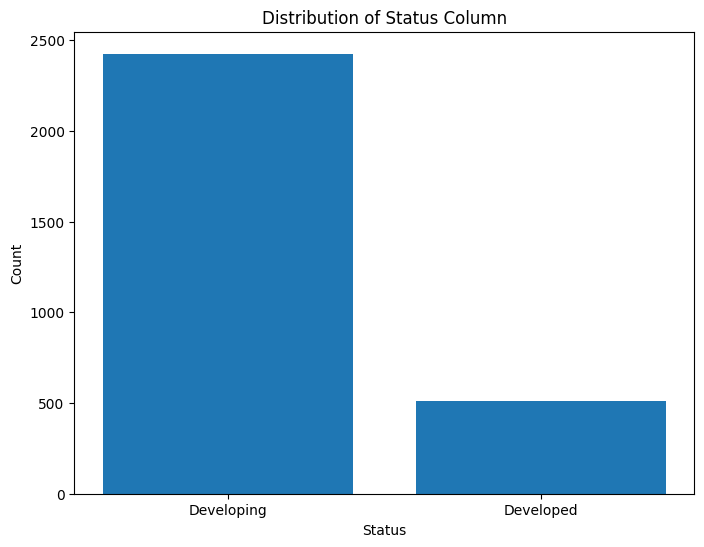

In [35]:
plt.figure(figsize=(8, 6)) 
plt.bar(df['Status'].value_counts().index, df['Status'].value_counts().values)
plt.title('Distribution of Status Column')
plt.xlabel('Status')
plt.ylabel('Count')
plt.show()

The `Status` column has a lot more developing countries than developed countries. Something to keep in mind when building the model.


In [36]:
years_per_country = df['Country'].value_counts()
countries_per_year_count = years_per_country.value_counts()
countries_per_year_count

count
16    183
1      10
Name: count, dtype: int64

The `Country` column has 183 rows that have a count of 16 and 10 rows that have a count of 1. This indicates that 183 countries have 16 years of data and 10 countries have only 1 year of data.


## **3. Data Preprocessing**

[Back to top](#Table-of-Contents)

---

In this step, I will be handling the missing values in the dataset, encoding the categorical columns, and splitting the data into training and testing sets.


#### **3.1 Handling Missing Values**


In [37]:
categorical = df.select_dtypes(include='object').columns
numerical = df.select_dtypes(exclude='object').columns
print(f'Categorical columns: {categorical}')
print(f'Numerical columns: {numerical}')

Categorical columns: Index(['Country', 'Status'], dtype='object')
Numerical columns: Index(['Year', 'Life expectancy', 'Adult Mortality', 'infant deaths',
       'Alcohol', 'percentage expenditure', 'Hepatitis B', 'Measles', 'BMI',
       'under-five deaths', 'Polio', 'Total expenditure', 'Diphtheria',
       'HIV/AIDS', 'GDP', 'Population', 'thinness  1-19 years',
       'thinness 5-9 years', 'Income composition of resources', 'Schooling'],
      dtype='object')


I'm seperating the categorical and numerical columns for easier preprocessing.


In [38]:
df[numerical].isnull().sum()

Year                                 0
Life expectancy                     10
Adult Mortality                     10
infant deaths                        0
Alcohol                            194
percentage expenditure               0
Hepatitis B                        553
Measles                              0
BMI                                 34
under-five deaths                    0
Polio                               19
Total expenditure                  226
Diphtheria                          19
HIV/AIDS                             0
GDP                                448
Population                         652
thinness  1-19 years                34
thinness 5-9 years                  34
Income composition of resources    167
Schooling                          163
dtype: int64

Let's replace the missing values in the dataset with the median values of the respective columns.


In [39]:
for col in numerical:
    df[col] = df[col].fillna(df[col].mean())
    
df[numerical].isnull().sum()

Year                               0
Life expectancy                    0
Adult Mortality                    0
infant deaths                      0
Alcohol                            0
percentage expenditure             0
Hepatitis B                        0
Measles                            0
BMI                                0
under-five deaths                  0
Polio                              0
Total expenditure                  0
Diphtheria                         0
HIV/AIDS                           0
GDP                                0
Population                         0
thinness  1-19 years               0
thinness 5-9 years                 0
Income composition of resources    0
Schooling                          0
dtype: int64

#### **3.2 Distribution of the Numerical Columns**


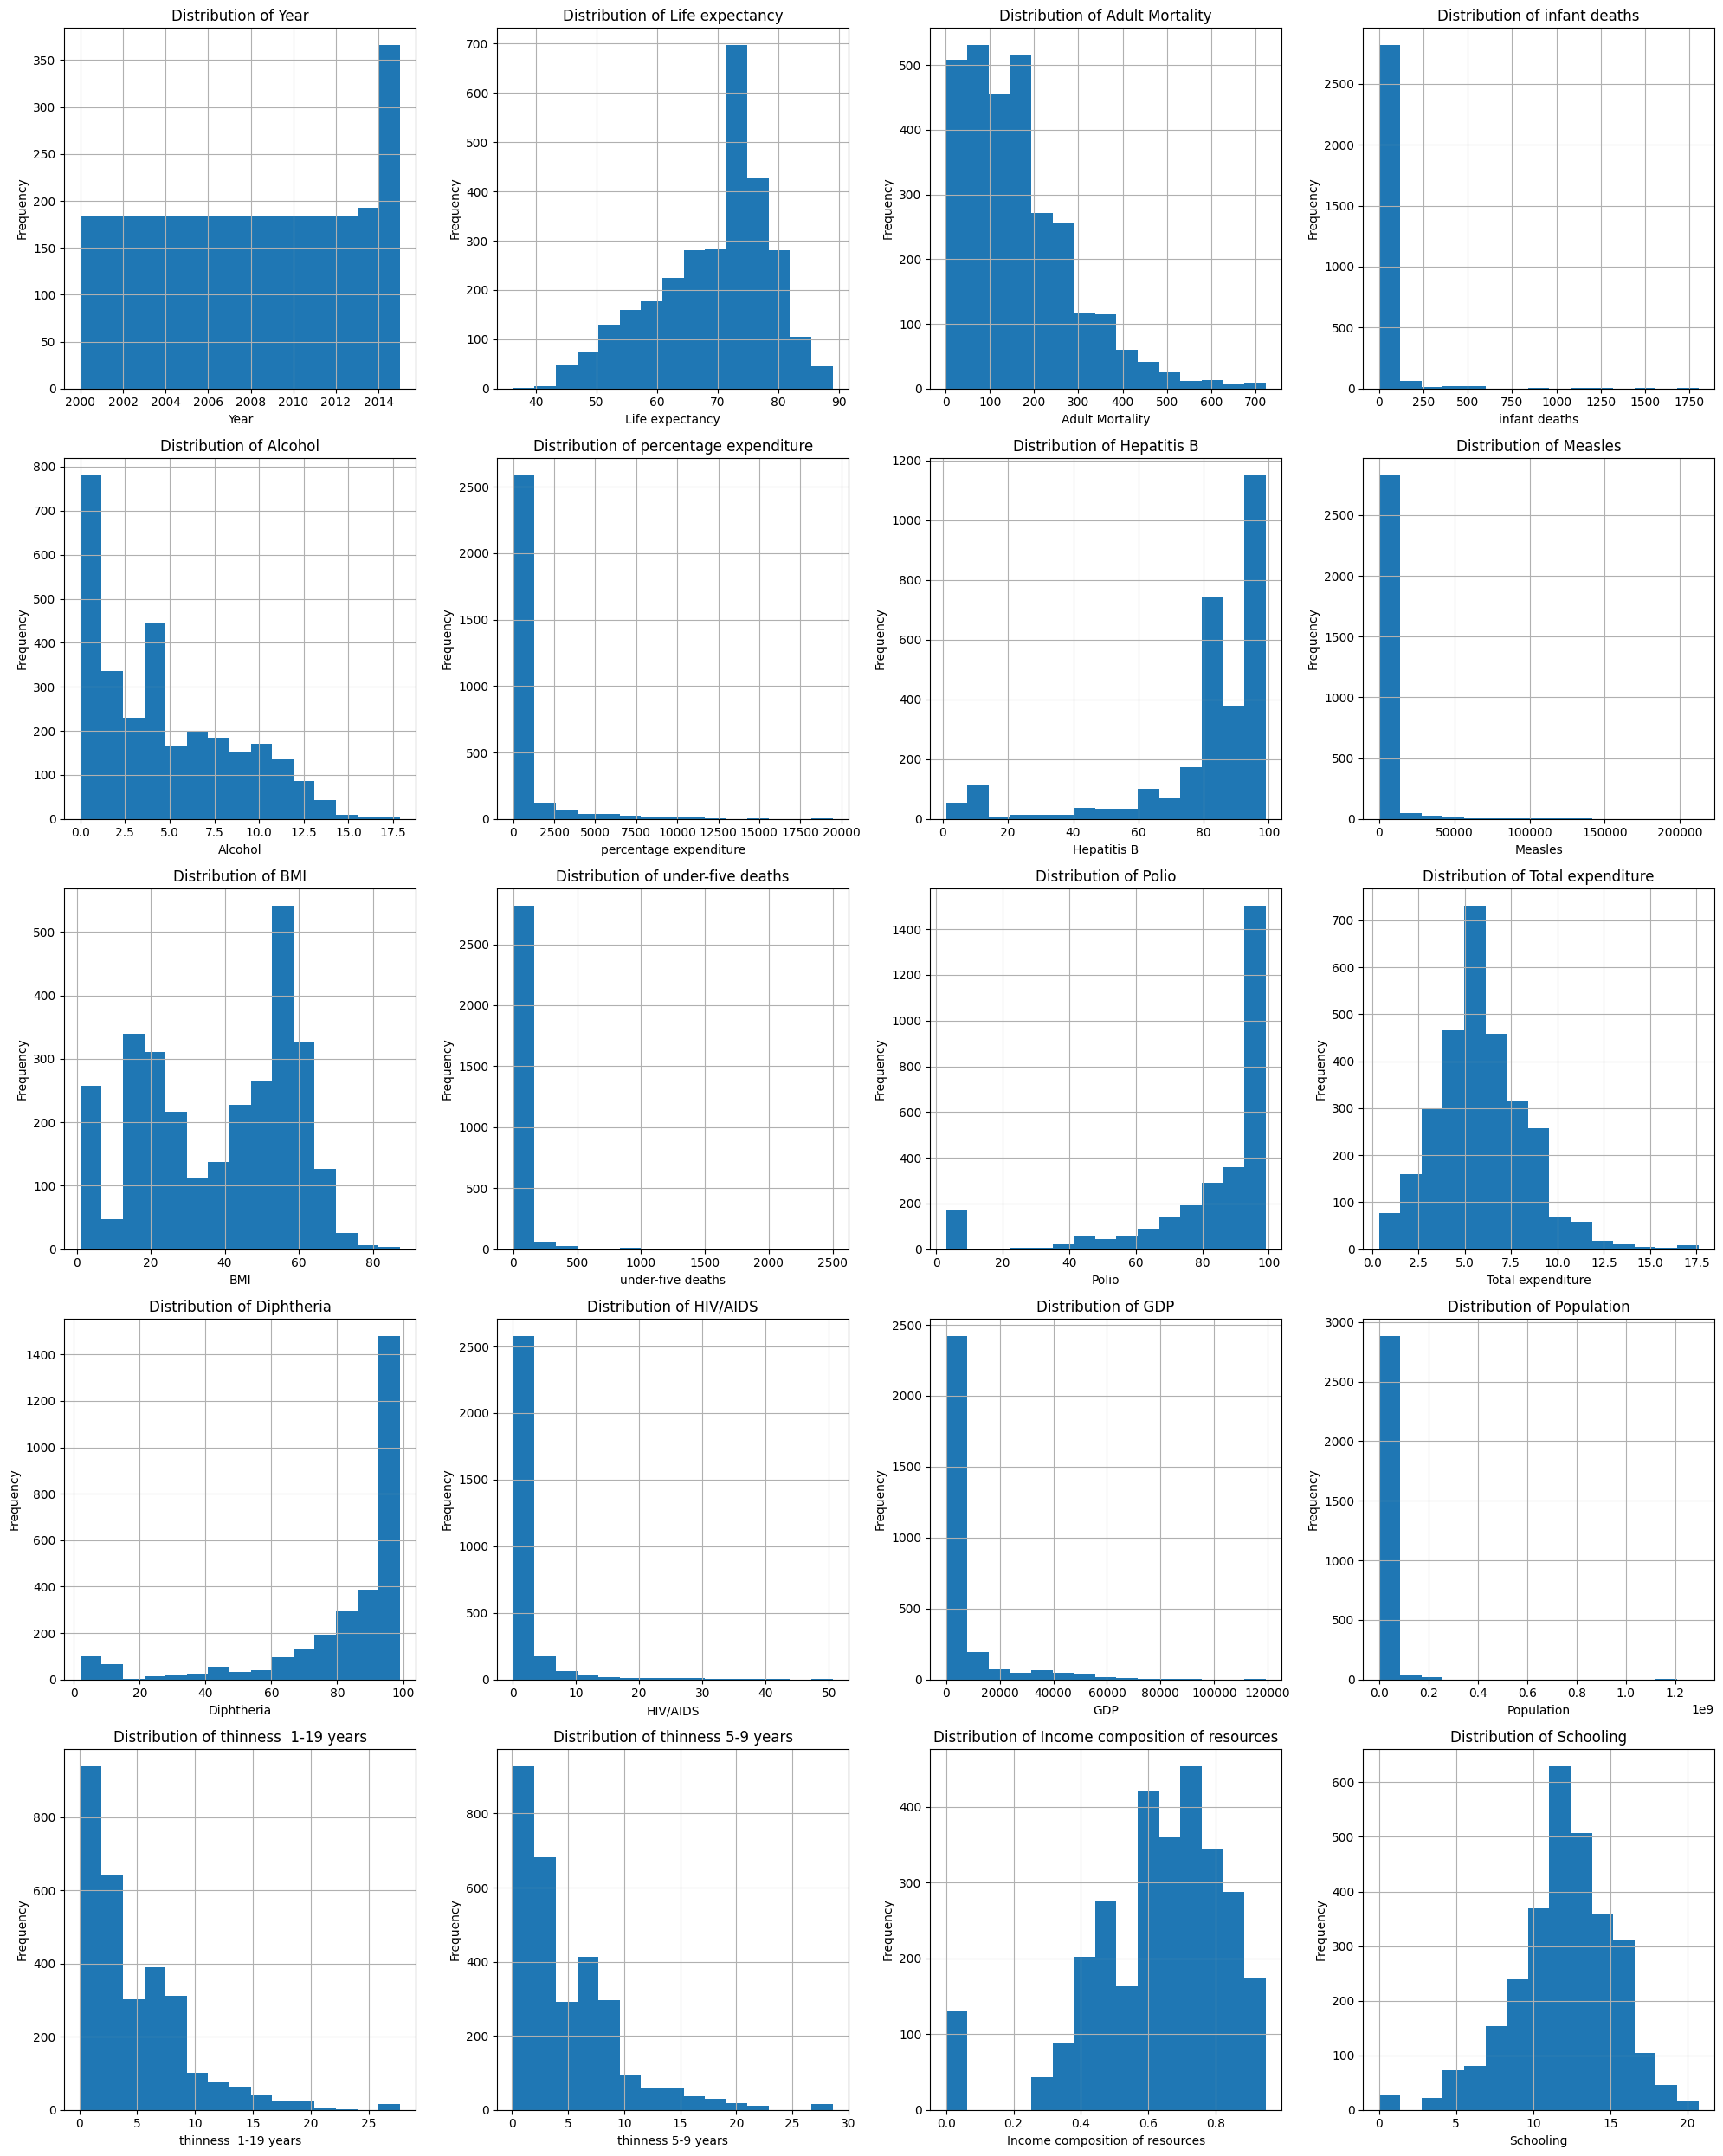

In [40]:
num_cols = len(numerical)
num_rows = num_cols // 4 + (num_cols % 4 > 0)

fig, axs = plt.subplots(num_rows, 4, figsize=(20, num_rows*5))

for i, col in enumerate(numerical): # enumerate() returns the index and the value of the column
    row_idx = i // 4
    col_idx = i % 4
    axs[row_idx, col_idx].hist(df[col], bins=15)
    axs[row_idx, col_idx].set_title(f'Distribution of {col}')
    axs[row_idx, col_idx].set_xlabel(col)
    axs[row_idx, col_idx].set_ylabel('Frequency')
    axs[row_idx, col_idx].grid(True)

plt.tight_layout()
plt.show()

As we can see, the distributions of some of the numerical columns are quite extreme. This also leads to a lot of outliers. I will however not be removing these outliers. I've tried previously to remove them, but it did not improve the model performance. Probably because ~70% of the data is considered an outlier...


#### **3.3 T-Test**

I will now perform a t-test to see if there is a significant difference in life expectancy between developed and developing countries.

In [41]:
developed = df[df['Status'] == 'Developed']['Life expectancy']
developing = df[df['Status'] == 'Developing']['Life expectancy']

t_stat, p_val = ttest_ind(developed, developing)

print(f'T-statistic: {t_stat}')
print(f'P-value: {p_val}')

mean_developed = developed.mean()
mean_developing = developing.mean()

print(f'Mean Life Expectancy (Developed): {mean_developed}')
print(f'Mean Life Expectancy (Developing): {mean_developing}')

T-statistic: 29.805188781530223
P-value: 9.034938663789684e-171
Mean Life Expectancy (Developed): 79.1978515625
Mean Life Expectancy (Developing): 67.12017696493812


The t-statistic of 29.805 indicates that there is a large difference between the group means relative to the variability within the groups. The p-value of 9.034938663789684e-171 is extremely small, indicating that the difference is very statistically significant.

#### **3.4 Encoding the Categorical Columns**

I will be encoding the `Status` column using one-hot encoding. The `Country` column will be dropped as it is not useful for the model. The reason for this is that the `Country` column has 193 unique values, which would lead to a lot of columns after one-hot encoding. This would make the model more complex and harder to interpret.


In [42]:
df = df.drop('Country', axis=1)
df.head()

,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,19.1,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,18.6,...,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,18.1,...,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,17.6,...,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,17.2,...,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


In [43]:
df = pd.get_dummies(df, columns=['Status'], drop_first=True)
df.head()

,Year,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,...,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling,Status_Developing
0,2015,65.0,263.0,62,0.01,71.279624,65.0,1154,19.1,83,...,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1,True
1,2014,59.9,271.0,64,0.01,73.523582,62.0,492,18.6,86,...,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0,True
2,2013,59.9,268.0,66,0.01,73.219243,64.0,430,18.1,89,...,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9,True
3,2012,59.5,272.0,69,0.01,78.184215,67.0,2787,17.6,93,...,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8,True
4,2011,59.2,275.0,71,0.01,7.097109,68.0,3013,17.2,97,...,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5,True


#### **3.5 Splitting and Scaling the Data**


In [44]:
X = df.drop('Life expectancy', axis=1)
y = df['Life expectancy']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

I will be scaling the numerical columns. This is important because the numerical columns have different scales, which can lead to the model being biased towards the columns with higher values. Seeing as the data has extreme distributions, I will be using the `RobustScaler` to scale the data. This scaler is robust to outliers and will scale the data based on the median and interquartile range.


In [45]:
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## **4. Building the Model**

[Back to top](#Table-of-Contents)

---

Now it's time to build the model. I will be using a few different linear regression models and compare their performance.


#### **4.1 Linear Regression**


In [46]:
model = LinearRegression()
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)

accuracy = model.score(X_test_scaled, y_test)
print(f'Accuracy: {accuracy}')

Accuracy: 0.8240562394240221


The model has an accuracy of 82.41%. Which is quite good considering the simplicity of the model.


In [47]:
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

rmse = np.sqrt(mse)
print(f'Root Mean Squared Error: {rmse}')

Mean Squared Error: 15.242936417631377
Root Mean Squared Error: 3.904220334155256


The mean squared error is 15.24 and the root mean squared error is 3.90. This means that the model's predictions are off by 3.90 years on average. This is quite good considering that the life expectancy values range from 36 to 89 years.

> MSE Tells you how close a regression line is to a set of points. It does this by taking the distances from the points to the regression line (these distances are the “errors”) and squaring them. The squaring is necessary to remove any negative signs. It also gives more weight to larger differences. It’s called the mean squared error as you’re finding the average of a set of errors.

> RMSE is the square root of the mean of the squared errors. It’s the most popular metric for evaluating regression models.


#### **4.2 Trying Different Models**

I will be trying different linear regression models to see if I can improve the performance of the model.

1. `Lasso Regression`
2. `Ridge Regression`
3. `Random Forest Regressor`
4. `Support Vector Regressor`


In [48]:
models = {
    'Lasso': Lasso(),
    'Ridge': Ridge(),
    'Random Forest': RandomForestRegressor(),
    'Support Vector Machine': SVR()
}

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    print(f'{name} Accuracy: {model.score(X_test_scaled, y_test)}')
    print(f'{name} RMSE: {rmse}\n')

Lasso Accuracy: 0.769811066340605
Lasso RMSE: 4.46570061788783

Ridge Accuracy: 0.8240656294011497
Ridge RMSE: 3.9041161502141257

Random Forest Accuracy: 0.9694334502025354
Random Forest RMSE: 1.6273111275375627

Support Vector Machine Accuracy: 0.7484276698220969
Support Vector Machine RMSE: 4.668515662092793



The Random Forest Regressor has the best performance with an RMSE of 1.64. This is a significant improvement over the Linear Regression model. The Random Forest Regressor is a more complex model and is able to capture the non-linear relationships in the data better than the Linear Regression model. Meaning that our data is not linear, therefore a linear model is not the best choice.


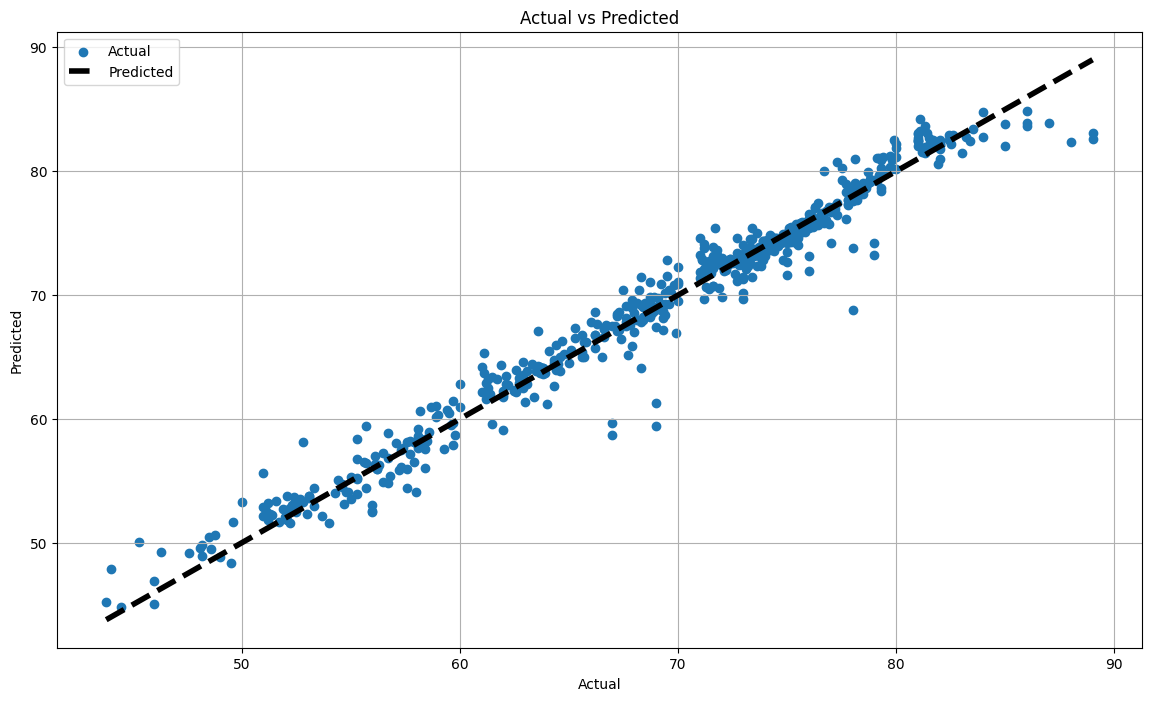

In [49]:
model = RandomForestRegressor()
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

plt.figure(figsize=(14, 8))
plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.grid(True)
plt.legend(['Actual', 'Predicted'])
plt.show()

We can see that the model is quite accurate in predicting the life expectancy values. The points are quite close to the line, which indicates that the model is making good predictions.


#### **4.3 Bias**


In [50]:
df['Predicted'] = model.predict(X)
df['Error'] = df['Life expectancy'] - df['Predicted']

bias = df.groupby('Status_Developing')['Error'].mean().sort_values(ascending=False)
bias

Status_Developing
False    3.351475
True     0.426562
Name: Error, dtype: float64

`Status_Developing` means that the country is a developing country. (e.g. Afghanistan, Albania, Algeria, Angola, etc.) When looking at the bias of the model, we can see that the model is biased towards developing countries. This means that the model is better at predicting the life expectancy of developing countries than developed countries.

## **5. XAI - SHAP**

[Back to top](#Table-of-Contents)

---

I will be using the SHAP library to explain the predictions of the Random Forest Regressor model. 

> SHAP (SHapley Additive exPlanations) in simple terms is a method to explain the output of machine learning models. It connects optimal credit allocation with local explanations using the classic Shapley values from game theory and their related extensions.

#### **5.1 Feature Importance**

The feature importance plot shows the most important features in the model. It's different from SHAP in the way that it shows the importance of the features in the model, not the impact of the features on the predictions.

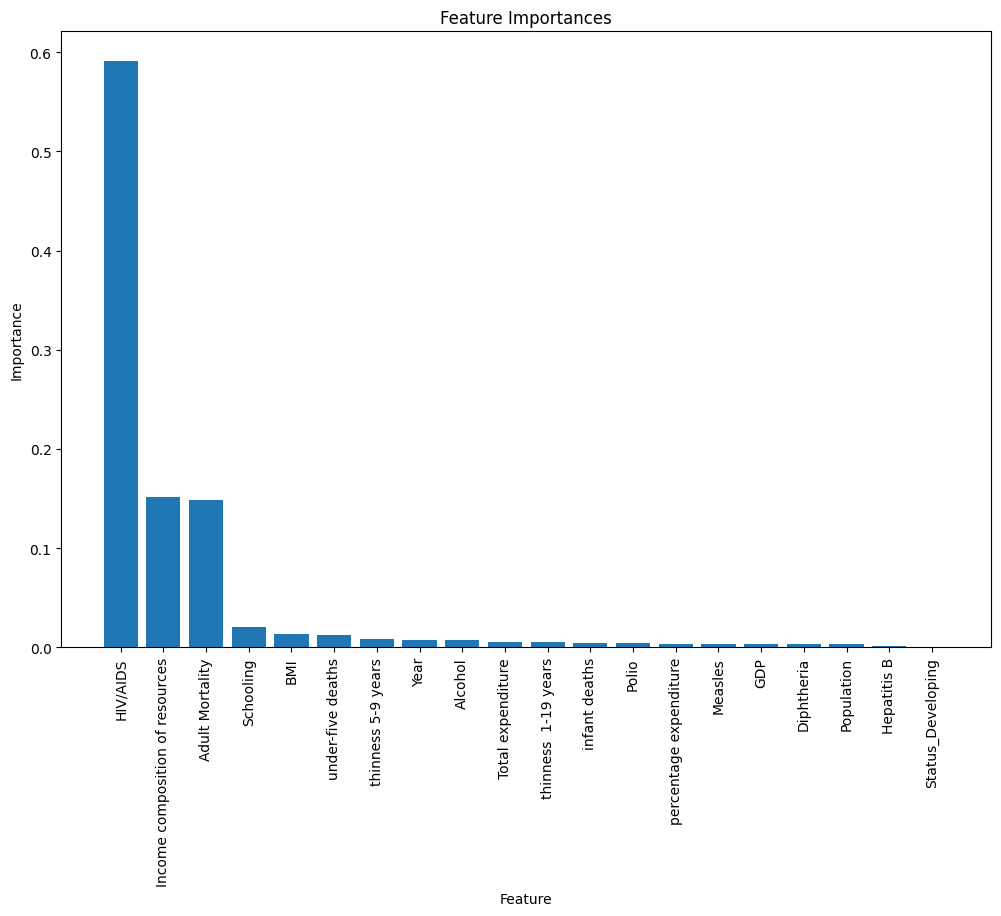

In [51]:
importances = model.feature_importances_
feature_names = X.columns

importances_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
})

importances_df = importances_df.sort_values('importance', ascending=False)

plt.figure(figsize=(12, 8))
plt.bar(importances_df['feature'], importances_df['importance'])
plt.title('Feature Importances')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.xticks(rotation=90)
plt.show()

In the above plot, we can see that `HIV/AIDS`, `Income composition of resources`, `Adult Mortality` are the most important features in the model. This means that these features have the most impact on the predictions of the model. This means that you could potentially improve the model by focusing on these features.

#### **5.2 SHAP Values**

The SHAP values show the impact of each feature on the predictions of the model. The SHAP values are calculated for each feature and each prediction. The SHAP values can be positive or negative, which indicates whether the feature is pushing the prediction up or down. Predictions, meaning the life expectancy in this case.

 99%|===================| 584/588 [00:14<00:00]        

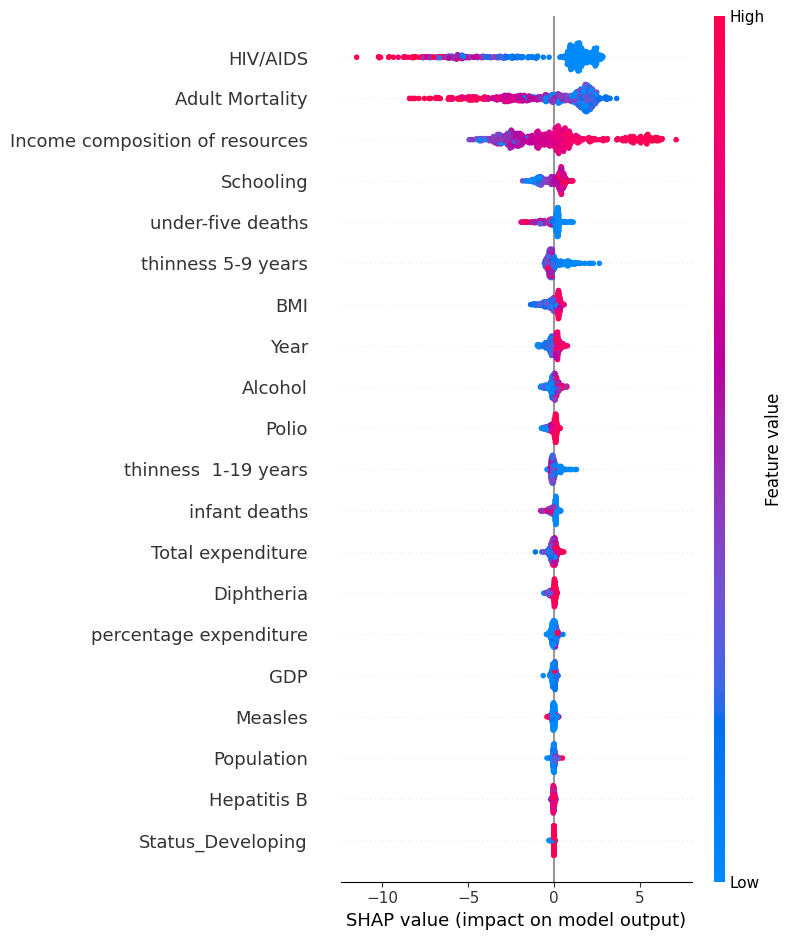

In [53]:
explainer = shap.Explainer(model, X_train_scaled)
shap_values = explainer(X_test_scaled)

shap.summary_plot(shap_values, X_test)

- The SHAP values on the x-axis represent the impact of the feature on the prediction.
- Positive SHAP values (to the right) increase the prediction, while negative SHAP values (to the left) decrease the prediction.
- The color gradient represents the value of the feature from low (blue) to high (red).
    - For example, a high value of `HIV/AIDS` (in red) increases the prediction, while a low value (in blue) decreases the prediction.
- The spread of points for each feature represents the interaction between life expectancy and the feature.
    - For example, `Income composition of resources` has a positive impact on the prediction, but the spread of points indicates that the impact is not consistent across all values of the feature. E.g. a high value of `Income composition of resources` does not always increase the prediction to the same extent.

## **6. Conclusion**

[Back to top](#Table-of-Contents)

---

In this notebook, I explored the WHO Life Expectancy dataset with the aim of understanding the relationship between health-related factors and life expectancy across 193 countries.

I started with examining the dataset, analyzing feature distributions, handling missing values, and encoding categorical variables. Moving forward, I used preprocessing techniques to address missing values and encode categorical variables, ensuring that the data was prepared for modeling. I also scaled numerical features to mitigate the impact of outliers and enhance model stability.

By evaluating each model using mean squared error (MSE) and root mean squared error (RMSE), I compared their performance. Ultimately, the Random Forest Regressor emerged as the best predictor, showing it could predict life expectancy more accurately.
